# 3D7 Finite Element Methods Laboratory

Copyright (C) 2023-2024 Garth N. Wells

In this lab exercise the finite element method is used to analyse the tensioned strip with a circular hole that was considered in the 3C7 lab.

## Objectives

1. Use a finite element package to solve linear elasticity equations.
1. Generate finite element meshes using a mesh generator.
1. Identify and define appropriate boundary conditions.
1. Analyse the influence of the mesh refinement on the final results.
1. Compare finite element results with experimental measurements and analytical solutions .


## Problem description

This lab exercise involves performing finite element analyses of a tensioned strip with a circular hole using various meshes. The quantity of interest is the stress field in the strip. The meshes are generated with [Gmsh](https://gmsh.info/) and the finite element analysis is performed with [FEniCSx](https://fenicsproject.org/).

The strip has the width $100$ mm, length $300$ mm, thickness $1.7$ mm and  hole radius $R = 14.8$ mm.  The strip is subjected to uniform tension of $\sigma_0$ applied at its two ends through. The total applied force is $F=10$ kN.

The Young's modulus is $E = 70$ GPa and Poisson's ratio is $\nu = 0.33$.

### Modelling

Symmetry can be exploited for the plate with a hole in the centre, allowing just one quarter of the plate to be modelled. Appropriate boundary conditions should be applied on the symmetry planes.

### Analysis

Explore the influence of mesh refinement on the computed solution. Your examination should include:
1. A uniform mesh (roughly the same cell size throughout the domain) with approximately 750 elements (linear element).

1. A uniform mesh with approximately 25,000 elements (linear element).

1. A locally refined mesh with approximately 1,000 elements (linear element).

1. Comparison of results for linear and quadratic elements (do not use an overly fine mesh)

1. Along the horizontal and vertical symmetry axes, plot the normal stress distributions calculated with the different meshes. Compare these stresses with those obtained for a hole in an infinite
plate that is stretched uniformly and also compare the stress at the periphery of
the hole with Howland"s analytical solution (see Appendix).

1. On the same graph plot the stresses measured experimentally in the 3C7 laboratory (if you did not do 3C7, you can download data from the 3D7 Moodle page).

1. Examining the von Mises stress contours indicates where yielding would first initiate in this strip. Estimate the applied stress $\sigma_0$ at which yielding initiates in a strip made from an Al-alloy (yield strength of the Al-alloy is 200 MPa).


### Post-processing and visualisation

It can be useful to explore computed solutions interactively. At points in the notebook, XMDF files are written. These files can be downloaded and visualised using [ParaView](https://www.paraview.org/).

### Off-centre hole analysis (Full Technical Report only)

> **Note:** This section is optional for the standard laboratory; result from this section
are not required in the
standard Laboratory Report. Students using this laboratory exercise for their Full
Technical Report must do this analysis in full and discuss it in their report.

Using a very fine reference mesh with linear triangles and a mesh of quadratic triangles
with far fewer cells, analyse the plate (length, width and thickness are the same as in the previous section) with
an off-centre hole. The plate is subjected to uniform tension of $\sigma_0$ applied at its two ends through a tensometer. The total applied force is $F=10$ kN. The distance
of the hole centre from the centre-line is $e = 16$ mm and the radius of the hole  is $R = 14.8$ mm. The material properties are the same as those used above.

Begin with a sketch of the boundary value problem to analyse (taking into account any symmetries) and then adjust the number of elements and their size distribution to obtain the greatest accuracy with a limited
number of cells. Plot the distributions of horizontal and vertical stress along axes passing through the centre of the hole and parallel to the sides of the plate.

## Write up

Finite element methods can produce vast amounts of data. Be selective in what you present. Careful selection of what to present is an important part of this exercise.

### Laboratory report (3 hours)

This should be word-processed and no more than three pages, excluding diagrams
and graphs. The report pertains only to the centred hole problem and should
contain your results from the Analysis section and discussion of the the below points, in addition to any other issues that you may wish to discuss.

1. Discuss reasons for any differences between the measured, analytical and finite element stresses and comment on the relative accuracies of the finite element models with the different meshes.

1. Briefly discuss the finite element modelling approach used to analyse the problem.

You may wish to use [ParaView](https://www.paraview.org/) to produce mesh and contour plots, and [Matplotlib](https://matplotlib.org/) for line plots (outside of this notebook).


### Full Technical Report (10 additional hours)

Guidance on the preparation of Full Technical Reports is provided in Appendix I of the
General Instructions document and in the CUED booklet *A Guide to Report Writing*,
with which you were issued in the first year. If you are submitting a Full Technical Report
on this experiment, you can either use the books indicated in the References section
below or do your own literature review. You should include your Laboratory report as an Appendix and refer to it as
appropriate.

The Full Technical Report should provide further investigation of aspects addressed in the lab.
You are free to pick topics that interest you, but must include:

1. Discuss the boundary conditions used to represent the off-centre hole problem.
How was rigid body motion prevented in this problem? The loading can also be applied by prescribing displacements (instead of applying traction) at one of the two ends of the plate. Implement this in the notebook and describe how this changes the results.

1. For the off-centre hole problem, plot the vertical and horizontal distributions along axes passing through the centre of the hole and parallel to the sides of the plate. Compare
these with the strain gauge measurements that you can download from Moodle (these are results
from the 3C7 Laboratory). The off-centre hole problem has no known analytical solution. Given more time,
how could you test the accuracy of your calculation of the stresses around the hole?

1. Examine the convergence of the problem, in a measure of interest, with mesh refinement.


# Finite element simulation

## Installing and importing the required modules

We first import the mesh generator [Gmsh](https://gmsh.info/) and the finite element library [DOLFINx](https://fenicsproject.org/).

When using Colab install scripts from https://fem-on-colab.github.io/ are used.

In [7]:
import sys
if "google.colab" in sys.modules:
    try:
        import gmsh
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
        import gmsh

    try:
        import dolfinx
    except ImportError:
        !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/dd3e6b7b1355000efe7865c3bb4980503c0d8eb6/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
        import dolfinx
else:
    import gmsh
    import dolfinx

Import the other required modules.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pyvista
import ufl

try:
    pyvista.start_xvfb()
except OSError:
    pass

# MPI communicator (this manages parallel computation, but we will run in serial)
from mpi4py import MPI

comm = MPI.COMM_WORLD

# PyVista global options
pyvista.global_theme.font.size = 12
pyvista.global_theme.font.title_size = 16
pyvista.global_theme.font.label_size = 12
pyvista.global_theme.background = "white"
pyvista.global_theme.font.color = "grey"

pyvista.global_theme.cmap = "jet"

## Generating the mesh

A mesh of a plate with a hole is generated using Gmsh. Note the lines that controls the mesh refinement.

In [9]:
length = 50  # half-length of the plate
width = 50   # half-width of the plate
r = 14.8  # radius of the hole
cx, cy = 0.0, 0.0  # Location of the centre of the hole

# Geometric dimension of the problem
gdim = 2

if gmsh.isInitialized():
    gmsh.finalize()
gmsh.initialize()

# Create a rectangle with the dimensions of the plate
# and a "disk" for the hole
rectangle = gmsh.model.occ.addRectangle(0, 0, 0, length, width, tag=1)
circle = gmsh.model.occ.addDisk(cx, cy, 0, r, r)

# Cut the disk (circle) from rectangle
plate = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, circle)])
gmsh.model.occ.synchronize()

# Create a physcal group
volumes = gmsh.model.getEntities(dim=2)
assert len(volumes) == 1
gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]])

# Option 1: Set the cell size for a mesh with a uniform cell size
gmsh.model.mesh.setSize(gmsh.model.getEntities(0), 10.0)

# Option 2: Set the a cell size field as a function of position.
# The below sets the size to be proportional to d^2, where d is the distance
# from the origin, and with a size of h_min on the circle. Changing the
# function changes how the cell size changes.
#
# h_min = 0.7  # Cell size at the hole
# hfield = gmsh.model.mesh.field.add("MathEval")  # Define a field on mesh
# gmsh.model.mesh.field.set_string(hfield, "F", f"{h_min} * ((x-{cx})^2 + (y-{cy})^2)/{r}^2")
# gmsh.model.mesh.field.setAsBackgroundMesh(hfield)

# Generate a mesh
gmsh.model.mesh.generate(gdim)

# Create a DOLFINx mesh from the Gmsh mesh
msh, _, _ = dolfinx.io.gmshio.model_to_mesh(gmsh.model, comm, 0, gdim=gdim)

# Finalise Gmsh session
gmsh.finalize()

print("Number of cells in the mesh:", msh.topology.index_map(2).size_local)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.000455701s, CPU 0.000374s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00175803s, CPU 0.001641s)
Info    : 46 nodes 95 elements
Number of cells in the mesh: 69


We can check the mesh visually.

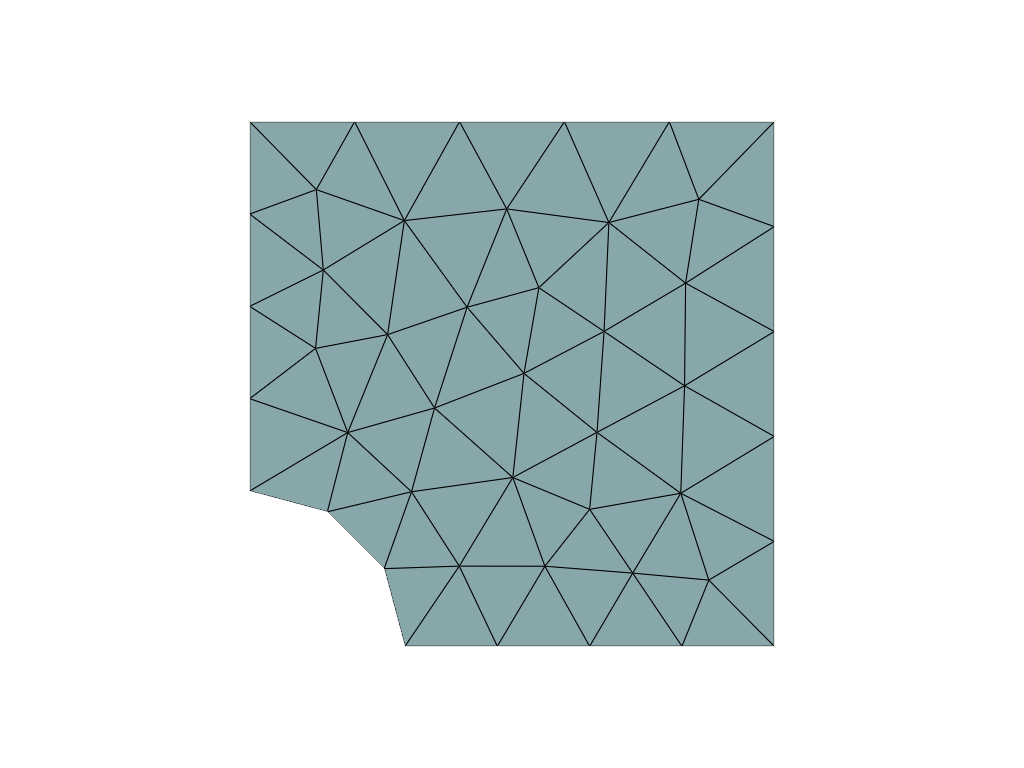

In [10]:
# Create a PyVista-compatible VTK mesh for plotting
cells, types, x = dolfinx.plot.vtk_mesh(msh)
grid = pyvista.UnstructuredGrid(cells, types, x)

pl = pyvista.Plotter(notebook=True)
pl.add_mesh(grid, show_edges=True)
pl.view_xy()
pl.show(jupyter_backend="static", return_viewer=True)

### Marking boundaries

We now find the cell facets on boundaries where boundary conditions will be applied.

For the RHS of the domain, where a Neumann (force) boundary condition will be applied, a 'mesh tag' `ft` is created with the marker `2`.

In [11]:
# Cell facets on the x_0 = 0 boundary
facets0 = dolfinx.mesh.locate_entities_boundary(msh, dim=1, marker=lambda x: np.isclose(x[0], 0.0))

# Cell facets on the x_1 = 0 boundary
facets1 = dolfinx.mesh.locate_entities_boundary(msh, dim=1, marker=lambda x: np.isclose(x[1], 0.0))

# Cell facets on the x_0 = L boundary and a marker function
facets2 = np.sort(dolfinx.mesh.locate_entities_boundary(msh, dim=1, marker=lambda x: np.isclose(x[0], length)))
ft = dolfinx.mesh.meshtags(msh, 1, facets2, values=2)

We can check visually that the RHS boundary has been tagged correctly by visualising the marker function.

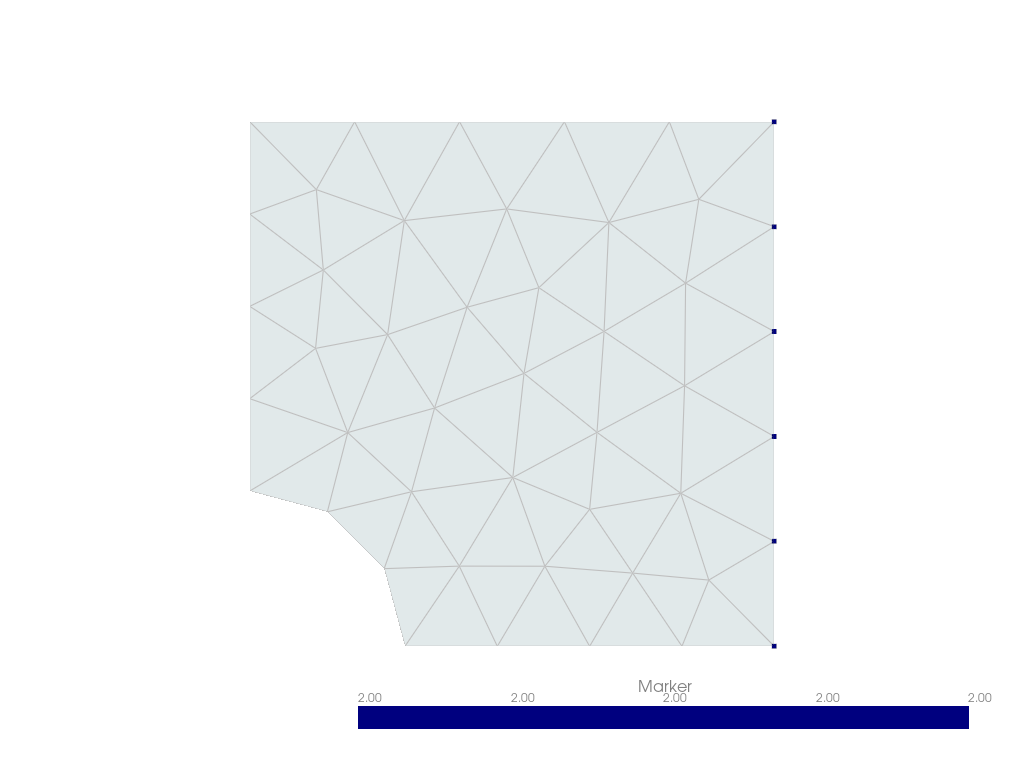

In [12]:
fcells, ftypes, fx = dolfinx.plot.vtk_mesh(msh, 1, ft.indices)
fgrid = pyvista.UnstructuredGrid(fcells, ftypes, fx)

fgrid.cell_data["Marker"] = ft.values
fgrid.set_active_scalars("Marker")

pl = pyvista.Plotter(notebook=True)
pl.add_mesh(fgrid, style="points")
pl.add_mesh(grid, opacity=0.25, show_edges=True)
pl.view_xy()
pl.show(jupyter_backend="static", return_viewer=True)

## Elasticity problem

The elasticity finite element problem is now defined.

### Model parameters

The Youngs modulus and the Poisson ration are set, and the Lame parameters computed.

In [13]:
E = 70000.0  # (N/mm^2)
ν = 0.33

### Finite element formulation

The finite element problem is now defined using DOLFINx.

> The degree of the finite element basis functions is set below by the variable `P`.

In [14]:
def σ(v):
    """Return an expression for the stress σ given a displacement field"""
    return (E / (1 + ν)) * ufl.sym(ufl.grad(v)) + (E * ν/(1 - ν * ν)) * ufl.tr(ufl.sym(ufl.grad(v))) * ufl.Identity(len(v))


# Applied traction (N/mm^2)
f = ufl.as_vector([58.0, 0.0])

# Boundary integral measure. The mesh tag is associated with the domain since
# the force term should be integrated only over the facets tagged '2'
ds = ufl.Measure("ds", subdomain_data=ft)

# Define the finite element function space of polynomial order P
P = 1
V = dolfinx.fem.functionspace(msh, ("Lagrange", P, (msh.geometry.dim,)))

# Create test and trial functions
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)

# Create bilinear and linear forms. The bilinear form is used to build the
# stiffness matrix and the linear form is used to generate the RHS vector.
a = ufl.inner(σ(u), ufl.grad(v)) * ufl.dx
L = ufl.inner(f, v) * ds(2)  # Integrate over domain "2" only

### Dirichlet boundary conditions

Dirichlet (displacement) boundary conditions are now represented. Earlier we found the facets on which boundary conditions should be applied. We now find the constrained degrees-of-freedoms on the facets and set the boundary condition value.

In [15]:
# Displacement boundary condition u_0 = 0.0 on x_0 = 0.0
dofs0 = dolfinx.fem.locate_dofs_topological(V.sub(0), entity_dim=1, entities=facets0)
bc0 = dolfinx.fem.dirichletbc(0.0, dofs0, V=V.sub(0))

# Displacement boundary condition u_1 = 0.0 on x_1 = 0.0
dofs1 = dolfinx.fem.locate_dofs_topological(V.sub(1), entity_dim=1, entities=facets1)
bc1 = dolfinx.fem.dirichletbc(0.0, dofs1, V=V.sub(1))

# Collect boundary conditions in a list
bcs = [bc0, bc1]

### Solve

The following solve the finite element problem, returning the finite element solution for the displacement field. The solve command forms the stiffness matrix and RHS vector, applies the Dirichlet boundary conditions to the linear system, and solves the problem. The dictionary `petsc_options` sets options for the linear solver.

In [16]:
from dolfinx.fem.petsc import LinearProblem
problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()
uh.name = "u"
print(f"Number of degrees-of-freedom: {uh.x.array.shape[0]}")

Number of degrees-of-freedom: 92


### View and save displacement field

A helpful first check is to visualise the deformed solution, magnified by a suitable scaling factor. This check can quickly identify issues with boundary conditions, e.g. correct direction of the loading.

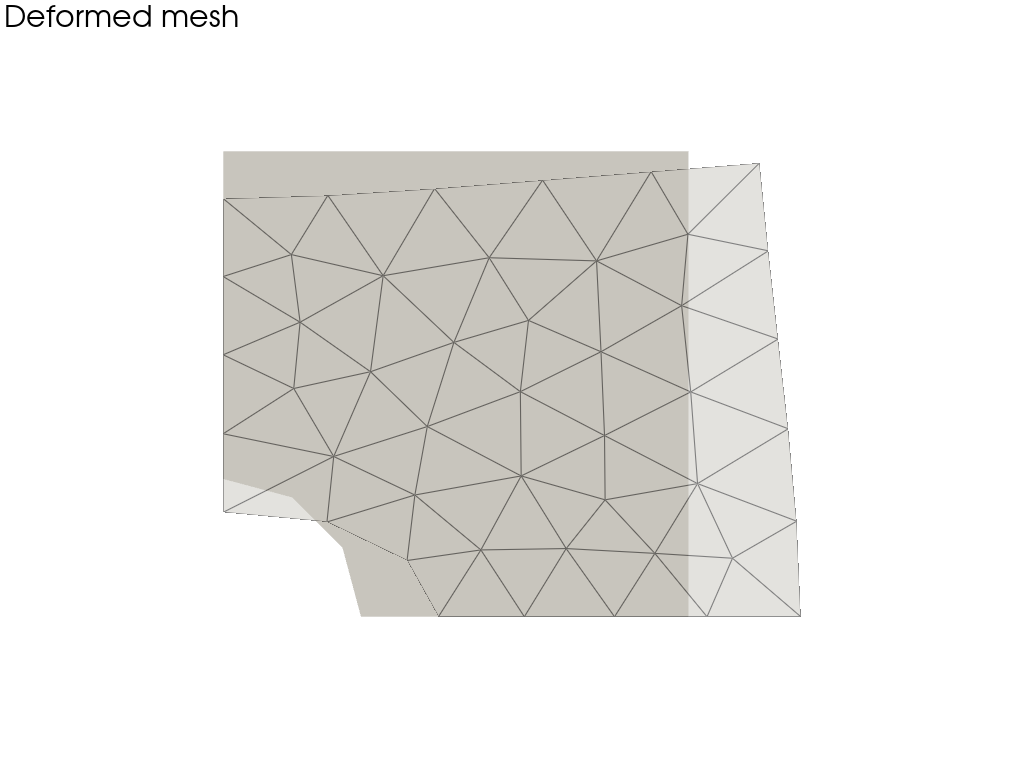

In [17]:
# Create a pyvista mesh and attach the values of u
cells, types, x = dolfinx.plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(cells, types, x)

# Attach solution values to the grid
values = np.zeros((x.shape[0], 3), dtype=np.float64)
values[:, :msh.topology.dim] = uh.x.array.reshape(x.shape[0], msh.topology.dim)
grid.point_data["u"] = values
grid.active_vectors_name = "u"

# Create a 'warped' version with the displacement magnified by a factor
warped = grid.warp_by_vector(factor=200.0)

# Plot
pl = pyvista.Plotter(notebook=True)
pl.add_mesh(grid, color="w", show_edges=False)
pl.add_mesh(warped, opacity=0.5, color="w", show_edges=True)
pl.add_text("Deformed mesh", color="k", font_size=12)
pl.view_xy()
pl.show(jupyter_backend="static", return_viewer=True)

Below contours of the displacement are displayed.

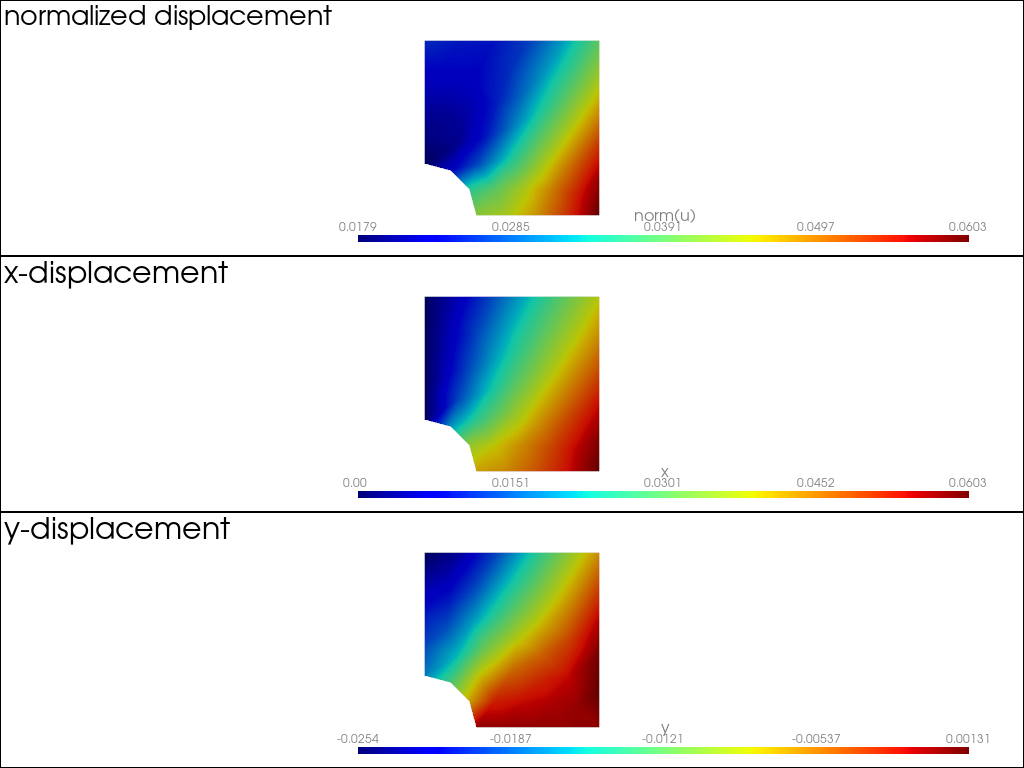

In [18]:
pl = pyvista.Plotter(shape=(3, 1), notebook=True)

pl.subplot(0, 0)
pl.add_mesh(grid.copy(), show_edges=False, scalars="u", scalar_bar_args={"title": "norm(u)"})
pl.add_text("normalized displacement", color="k", font_size=12)

pl.subplot(1, 0)
pl.add_mesh(grid.copy(), component=0, scalar_bar_args={"title": "x"})
pl.add_text("x-displacement", color="k", font_size=12)

pl.subplot(2, 0)
pl.add_mesh(grid.copy(), component=1, scalars="u", scalar_bar_args={"title": "y"})
pl.add_text("y-displacement", color="k", font_size=12)

pl.link_views()
pl.view_xy()
pl.show(jupyter_backend="static", return_viewer=True)

The displacement field is saved to file.

> **Note:** There will be a folder with `.bp` extension. The solution field can be visualised using [ParaView](https://www.paraview.org/).

> **Note**: Files written in Colab can be seen by clicking the 'files' icon on the left-hand side bar, and from there downloaded.

In [19]:
with dolfinx.io.VTXWriter(msh.comm, "u.bp", uh, engine="bp4") as file:
    file.write(0.0)

## Post-processing of the stress field

We compute the stress field from the displacement field. Note that the computed stress is discontinuous, therefore we will use a discontinuous finite element space to store it. We use DOLFINx to compute the stress field from the displacement field.

Stress is actually a second-order tensor (roughly speaking, matrix). PyVista expects a $3 \times 3$ stress tensor:
$$
\sigma =
\begin{bmatrix}
\sigma_{xx} & \sigma_{xy} & \sigma_{xz} \\
\sigma_{yx} & \sigma_{yy} & \sigma_{yz} \\
\sigma_{zx} & \sigma_{zy} & \sigma_{zz}
\end{bmatrix}
$$
The stress tensor must be symmetric.

In [20]:
# Stress from the computed displacement field
sigma = σ(uh)

# Evalate the stress field
gdim = msh.geometry.dim
W = dolfinx.fem.functionspace(msh, ("Discontinuous Lagrange", P - 1, (gdim, gdim)))
sigma_expr = dolfinx.fem.Expression(sigma, W.element.interpolation_points())
sigma_h = dolfinx.fem.Function(W, name="sigma")
sigma_h.interpolate(sigma_expr)

### Full stress field

We first visualise the stress components.
PyVista indexes the components of the stress tensor using an integer with row-major layout, i.e. `0` for $\sigma_{xx}$, `1` for $\sigma_{xy}$, `2` for $\sigma_{xz}$, `3` for $\sigma_{yx}$, and so forth.

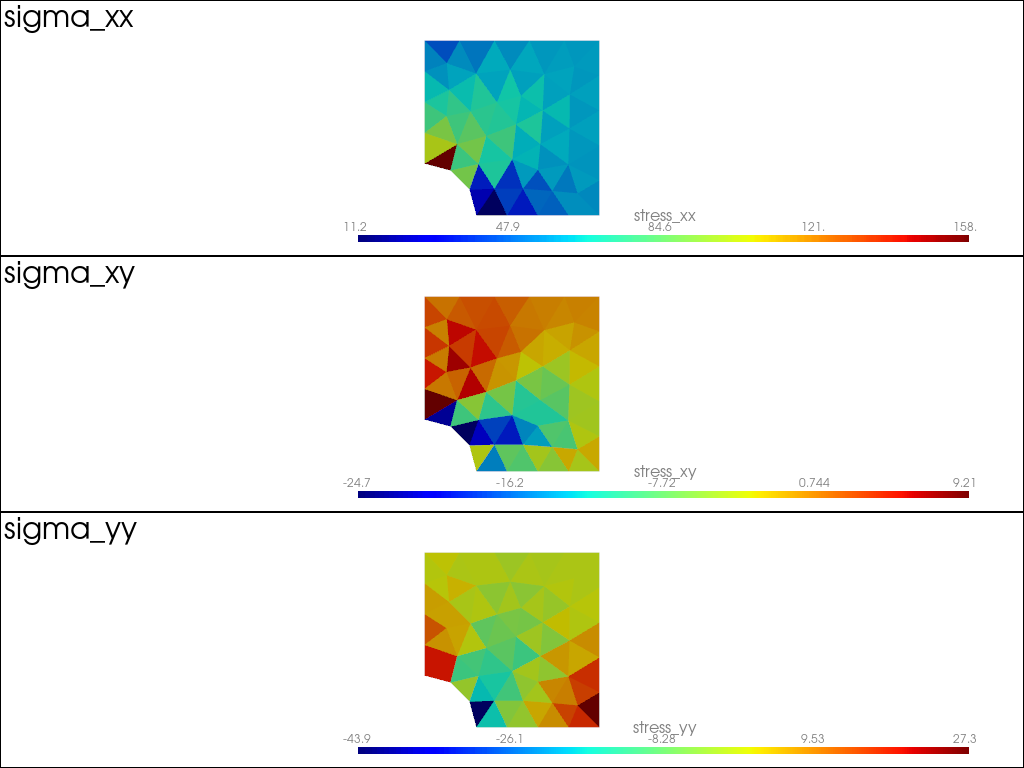

In [21]:
# The plotting in this section works for piecewise-constant stresses only

# Plots the xx, xy and yy components of the stress
pl = pyvista.Plotter(shape=(3, 1), notebook=True)
if P == 1:
    # Plotting here assumes a specific orderong of dofs. This assertion checks
    # the the assumption is true
    assert np.array_equal(W.dofmap.list.flatten(), range(W.dofmap.list.shape[0]))

    num_cells = msh.topology.index_map(msh.topology.dim).size_local

    # Attach the stress 'degrees-of-freedom' to the grid (3x3 tensor)
    values = np.zeros((num_cells, 3, 3), dtype=np.float64)
    values[:, :2, :2] = sigma_h.x.array.reshape(num_cells, 2, 2)
    grid.cell_data["sigma"] = values

    pl.subplot(0, 0)
    pl.add_mesh(grid.copy(),  component=0, show_edges=False, scalars="sigma", scalar_bar_args={"title": "stress_xx"})
    pl.add_text("sigma_xx", color="k", font_size=12)

    pl.subplot(1, 0)
    pl.add_mesh(grid.copy(),  component=1, show_edges=False, scalars="sigma", scalar_bar_args={"title": "stress_xy"})
    pl.add_text("sigma_xy", color="k", font_size=12)

    pl.subplot(2, 0)
    pl.add_mesh(grid.copy(),  component=4, show_edges=False, scalars="sigma", scalar_bar_args={"title": "stress_yy"})
    pl.add_text("sigma_yy", color="k", font_size=12)

    pl.link_views()
    pl.view_xy()
pl.show(jupyter_backend="static", return_viewer=True)

We also save the stress field to file for more detailed analysis using ParaView.
> **Note:** If the polynomial degree, P, for the displacement field is 1, the stress field is cell-wise constant. Since, the plotting of cell-wise constant is not supported in ``.bp`` format, we interpolate the stress field to the discontinuous Lagrange space of polynomial order 1.

In [22]:
if P == 1:
    # Define discontinuous Lagrange finite element function space of polynomial order 1
    W_plot = dolfinx.fem.functionspace(msh, ("Discontinuous Lagrange", 1, (gdim, gdim)))

    sigma_h_expr_plot = dolfinx.fem.Expression(sigma, W_plot.element.interpolation_points())
    sigma_h_plot = dolfinx.fem.Function(W_plot)

    # Interpolate the computed stress field
    sigma_h_plot.interpolate(sigma_h_expr_plot)

    # Plot the interpolated field
    with dolfinx.io.VTXWriter(msh.comm, "stress.bp", sigma_h_plot, engine="bp4") as file:
        file.write(0.0)
else:
    with dolfinx.io.VTXWriter(msh.comm, "stress.bp", sigma_h, engine="bp4") as file:
        file.write(0.0)

### Stress components along axes

#### $x$-axis

Evaluate stress along $x_{1} = 0$ ($y = 0$) axis.

We create points at which to evaluate the solution.

In [23]:
# Evaluation points along y = 0 (note that y is slightly larger
# than 0 - this ensures that evaluations are inside the domain)
eps = 0.00001
xp = np.zeros([400, 3])
xp[:, 0] = np.linspace(r + eps, length - eps, xp.shape[0])
xp[:, 1] = 1.0e-8

In [24]:
# Analytical expression for an infinite plate with a hole
sigma_xx_x0 = np.ones(xp.shape[0]) - 5 * r * r / (2*np.power(xp[:, 0], 2)) + 3*np.power(r, 4)/(2*np.power(xp[:, 0], 4))
sigma_yy_x0 = r**2/(2*np.power(xp[:, 0], 2)) - 3*r**4/(2*np.power(xp[:, 0], 4))

In [25]:
# Find the cells that contain the evaluation points
tree = dolfinx.geometry.bb_tree(msh, msh.geometry.dim)
cell_candidates_px = dolfinx.geometry.compute_collisions_points(tree, xp)
cells_px = dolfinx.geometry.compute_colliding_cells(msh, cell_candidates_px, xp)
assert xp.shape[0] == cells_px.array.shape[0]

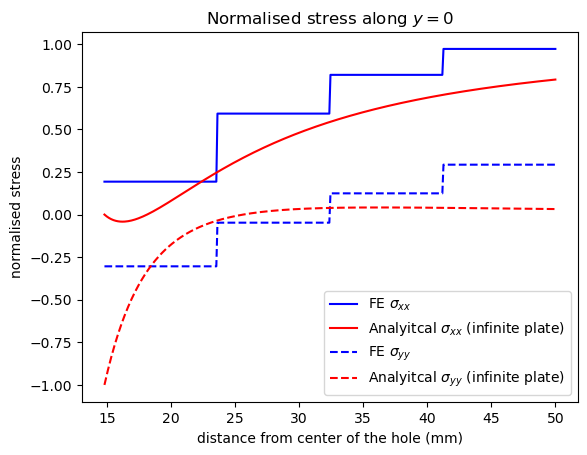

In [26]:
# Evaluate stress at the points, and reshape into a 2x2 tensor at each point
sigma_bottom = sigma_h.eval(xp, cells_px.array)
sigma_tensor = sigma_bottom.reshape(xp.shape[0], 2, 2)

# Normalise by the load
sigma_tensor /= 58.0

# Plot
plt.plot(xp[:, 0], sigma_tensor[:, 0, 0], "b-", label="FE $\sigma_{xx}$")
plt.plot(xp[:, 0], sigma_xx_x0, "r-", label="Analyitcal $\sigma_{xx}$ (infinite plate)")

plt.plot(xp[:, 0], sigma_tensor[:, 1, 1], "b--", label="FE $\sigma_{yy}$")
plt.plot(xp[:, 0], sigma_yy_x0, "r--", label="Analyitcal $\sigma_{yy}$ (infinite plate)")

plt.title("Normalised stress along $y=0$")
plt.ylabel("normalised stress")
plt.xlabel("distance from center of the hole (mm)")
plt.legend()
plt.show()

Save to file for further processing, possibly outside of the notebook, e.g.:

In [27]:
np.savetxt("x.txt", xp[:, 0])
np.savetxt("sigma_h_xx_y0.txt", sigma_tensor[:, 0, 0])
np.savetxt("sigma_xx_x0.txt", sigma_xx_x0)

#### $y$-axis

Evaluate stress along $x_{0} = 0$ ($x = 0) axis.

> Note the lines for plotting the adding the experimentally measured stresses. Use your own experimental data from 3C7. If you did not do the 3C7 lab, data can be found on the course VLE page.


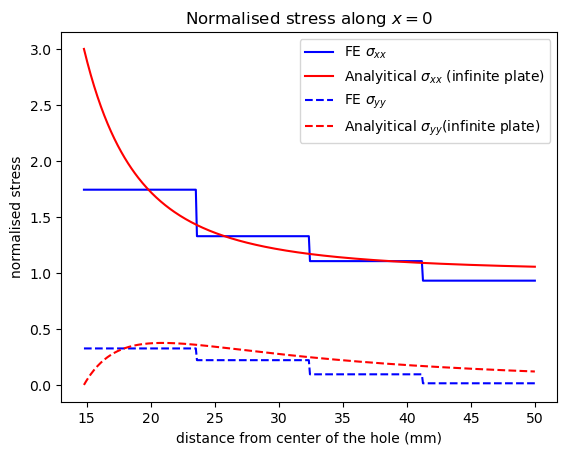

In [28]:
yp = np.zeros([400, 3])
eps = 1.0e-5
yp[:, 1] = np.linspace(r + eps, width - eps, yp.shape[0])
yp[:, 0] = 1.0e-8

# Analytical expression for an infinite plate with a hole
sigma_xx_x1 = np.ones(yp.shape[0]) + r**2 / (2*np.power(yp[:, 1], 2)) + 3*r**4/(2*np.power(yp[:, 1], 4))
sigma_yy_x1 = (3.0 / 2.0) * (r**2 / np.power(yp[:, 1], 2) - r**4 / np.power(yp[:, 1], 4))

# Find the cells that contain the evaluation points
cell_candidates_py = dolfinx.geometry.compute_collisions_points(tree, yp)
cells_py = dolfinx.geometry.compute_colliding_cells(msh, cell_candidates_py, yp)
assert yp.shape[0] == cells_py.array.shape[0]

# Evaluate stress at the points, and reshape into a 2x2 tensor at each point
sigma_side = sigma_h.eval(yp, cells_py.array)
sigma_tensor = sigma_side.reshape(yp.shape[0], 2, 2)

# Normalise by the load
sigma_tensor /= 58.0

# Plot
plt.plot(yp[:, 1], sigma_tensor[:, 0, 0], "b-", label="FE $\sigma_{xx}$")
plt.plot(yp[:, 1], sigma_xx_x1, "r-", label="Analyitical $\sigma_{xx}$ (infinite plate)")

# Experimental data
# sigmaxx_exp = np.loadtxt("symmetric_plate1.txt")
# plt.plot(np.flip(sigmaxx_exp[:, 1]), np.flip(sigmaxx_exp[:,0]), "g-",label="Experimental $\sigma_{xx}$")

plt.plot(yp[:, 1], sigma_tensor[:, 1, 1], "b--", label="FE $\sigma_{yy}$")
plt.plot(yp[:, 1], sigma_yy_x1, "r--", label="Analyitical $\sigma_{yy}$(infinite plate)")

plt.title("Normalised stress along $x=0$")
plt.ylabel("normalised stress")
plt.xlabel("distance from center of the hole (mm)")
plt.legend()
plt.show()

### Von Mises stress

The deviatoric stress is defined as
$$
\boldsymbol{s} = \boldsymbol{\sigma} - \frac{1}{3} {\rm tr} \sigma \boldsymbol{I}
$$
or in indices,
$$
s_{ij} = \sigma_{ij} - \frac{\sigma_{kk}}{3} \delta_{ij}
$$
The von Mises stress is equal to $\sqrt{2 J_{2}}$, where $\sqrt{2 J_{2}}$ is the second invariant of the deviatoric stress. The von Mises stress is given by:
$$
\sigma_{v} = \sqrt{\frac{3}{2} s_{ij} s_{ij}}
$$

In [29]:
# Deviatoric stress (symbolic expression)
s = sigma_h - (1.0/3) * ufl.tr(sigma_h) * ufl.Identity(2)

# Von Mises stress (symbolic expression)
sigma_vm = ufl.sqrt((3.0/2.0) * ufl.inner(s, s))

# Evaluate the Von Mises stress
Q = dolfinx.fem.functionspace(msh, ("Discontinuous Lagrange", P - 1))
sigmavm_expr = dolfinx.fem.Expression(sigma_vm, Q.element.interpolation_points())
sigmavm_h = dolfinx.fem.Function(Q)
sigmavm_h.interpolate(sigmavm_expr)

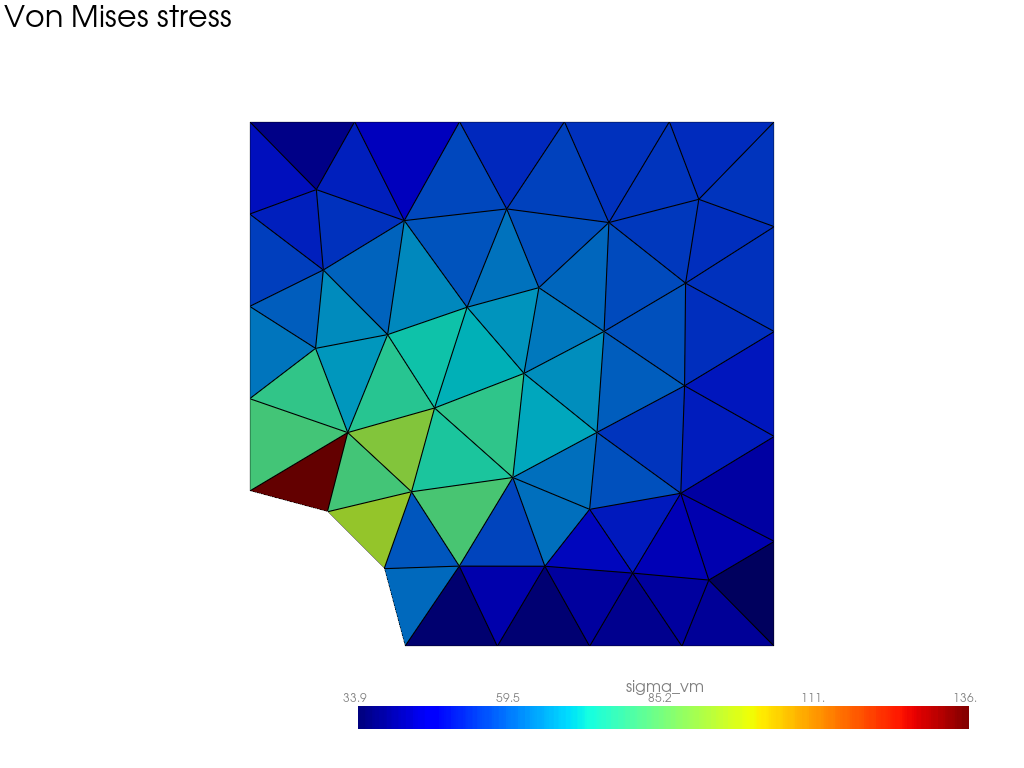

In [30]:
# The plotting in this section works for piecewise-constant stresses only
pl = pyvista.Plotter(notebook=True)
if P == 1:
    # Plotting here assumes a specific orderong of dofs. This assertion checks
    # the the assumption is true
    assert np.array_equal(Q.dofmap.list.flatten(), range(Q.dofmap.list.shape[0]))

    # Get VTK/PyVista mesh data and create a PyVista grid
    cells, types, x = dolfinx.plot.vtk_mesh(msh)
    grid = pyvista.UnstructuredGrid(cells, types, x)

    num_cells = msh.topology.index_map(msh.topology.dim).size_local

    # Attach the Von Mises stress 'degrees-of-freedom'
    grid.cell_data["sigma_vm"] = sigmavm_h.x.array

    pl.add_mesh(grid, show_edges=True)
    pl.add_text("Von Mises stress", color="k", font_size=12)
    pl.view_xy()
else:
    print("PyVista plotting of discontinuous functions is supported only for piece-wise constants.")

pl.show(jupyter_backend="static", return_viewer=True)

In [31]:
if P == 1:
    # Define discontinuous Lagrange finite element function space of polynomial order 1
    Q_plot = dolfinx.fem.functionspace(msh, ("Discontinuous Lagrange", 1))
    sigmavm_expr_plot = dolfinx.fem.Expression(sigma_vm, Q_plot.element.interpolation_points())
    sigmavm_h_plot = dolfinx.fem.Function(Q_plot)

    # Interpolate the computed von Mises stress field
    sigmavm_h_plot.interpolate(sigmavm_expr_plot)

    # Plot the interpolated field
    with dolfinx.io.VTXWriter(msh.comm, "vm.bp", sigmavm_h_plot, engine="bp4") as file:
        file.write(0.0)
else:
    with dolfinx.io.VTXWriter(msh.comm, "vm.bp", sigmavm_h, engine="bp4") as file:
        file.write(0.0)

# Appendix: analytical solutions


## Infinite plate

There are several analytical solutions
for the stress distributions in thin plates with circular holes.
The best known is the solution for a circular hole of radius $R$
in an infinite plate,

![Infinite plate](https://raw.githubusercontent.com/garth-wells/3D7Lab/main/handout/figs/infinite-plate.svg?token=GHSAT0AAAAAABX4UUKMCZHG444XPPZUFN4EZOIWPDA)

(S.P. Timoshenko and J.N. Goodier, Theory of Elasticity, p. 90-93.)
The stress components on the centre lines are given by

$x$-axis:
\begin{align}
\frac{\sigma_{xx}}{\sigma_0 } &= 1 -\frac{5R^2 }{2x^2 } + \frac{3R^4}{2x^4 }\\
\frac{\sigma_{yy}}{\sigma_0} &= \frac{R^2}{2x^2} - \frac{3R^4}{2x^4}
\end{align}

$y$-axis:
\begin{align}
\frac{\sigma _{xx}}{\sigma _0} &= 1 + \frac{R^2}{2y^2} + \frac{3R^4}{2y^4} \\
\frac{\sigma _{yy}}{\sigma _0} &= \frac{3}{2}\left( \frac{R^2}{y^2} -
\frac{R^4}{y^4} \right)
\end{align}

Both axes:
$$
 \sigma_{xy} =0
$$

The stress concentration decays
rather quickly away from the hole. Therefore, this solution can
be used for non-infinite plates, provided that the edges of the
plate are sufficiently far from the hole that the stresses on the
edges are approximately equal to the remote stress field. If this
is not the case, alternative solutions may
be used.

## Howland solution

![Finite plate](https://raw.githubusercontent.com/garth-wells/3D7Lab/main/handout/figs/finite-plate.svg?token=GHSAT0AAAAAABX4UUKNWMRNWEYRC6ZJ5VH6ZOIWPYQ)

Howland (Howland, R.C.J. (1930). On the stresses in the
neighbourhood of a circular hole in a strip under tension.
Philosophical Transactions of the Royal Society of London A, 229,
49-86.) derived semi-analytical expressions for the stress
concentration factors at the edge of a symmetric hole of radius
$R$ in a plate of finite width $2W$. These factors have been
calculated for a range of plate geometries and are shown in the
table below.


Stress concentration factors:

| $R/W$     | Point A                    |   Point B                         |
|:---------:|:--------------------------:|:--------------------------:|
|           | $\dfrac{\sigma_{xx}}{\sigma_{0}}$   | $\dfrac{\sigma_{yy}}{\sigma_{0}}$   |
| $0$       | $3.00$                     | $-1.00$                    |
| $0.1$     | $3.03$                     | $-1.03$                    |
| $0.2$     | $3.14$                     | $-1.11$                    |
| $0.3$     | $3.36$                     | $-1.26$                    |
| $0.4$     | $3.74$                     | $-1.44$                    |
| $0.5$     | $4.32$                     | $-1.58$                    |
